In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

sns.set_style('whitegrid')
print("Libraries imported.")

# --- LOAD FEATURED DATA ---
try:
    master_df_featured = pd.read_csv('../data/featured_data.csv', parse_dates=['Date'])
    print("Featured data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'featured_data.csv' not found. Please run notebook 02 first.")


Libraries imported.
Featured data loaded successfully.


In [2]:
# === DATA PREPARATION ===
df_for_model = master_df_featured.copy()

# -- Time-Series Split --
cutoff_date = '2012-01-01'
train_df = df_for_model[df_for_model['Date'] < cutoff_date].copy()
val_df   = df_for_model[df_for_model['Date'] >= cutoff_date].copy()

# -- Target Encoding (Store & Dept) --
store_sales_map = train_df.groupby('Store')['Weekly_Sales'].mean()
dept_sales_map  = train_df.groupby('Dept')['Weekly_Sales'].mean()

train_df['Store_Encoded'] = train_df['Store'].map(store_sales_map)
train_df['Dept_Encoded']  = train_df['Dept'].map(dept_sales_map)
val_df['Store_Encoded']   = val_df['Store'].map(store_sales_map)
val_df['Dept_Encoded']    = val_df['Dept'].map(dept_sales_map)

# -- One-Hot Encoding ('Type') --
train_df = pd.get_dummies(train_df, columns=['Type'], drop_first=True)
val_df   = pd.get_dummies(val_df, columns=['Type'], drop_first=True)
val_df = val_df.reindex(columns=train_df.columns, fill_value=0)

# -- Filling any remaining NaNs from the merge/map step --
train_global_mean = train_df['Weekly_Sales'].mean()
val_df.fillna(train_global_mean, inplace=True)

In [3]:
# --- Final Prep & Scaling ---
TARGET = 'Weekly_Sales'

# Defining all columns that should NOT be in our final feature set
# This includes the target, original IDs, and the categorical columns we created for EDA
eda_cat_cols = ['Temp_Category', 'Fuel_Price_Category', 'CPI_Category', 'Unemployment_Category']
cols_to_drop = [TARGET, 'Date', 'Store', 'Dept'] + eda_cat_cols

# Creating the final list of features by excluding the ones in cols_to_drop
FEATURES = [col for col in train_df.columns if col not in cols_to_drop]

# Separating features (X) and target (y)
X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_val   = val_df[FEATURES]
y_val   = val_df[TARGET]

# Standardize numerical features (fit scaler on training only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Converting back to DataFrames for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES)
X_val_scaled   = pd.DataFrame(X_val_scaled, columns=FEATURES)

print("Step 4 Complete: Data prepared and scaled for modeling.")
display(X_train_scaled.head())

Step 4 Complete: Data prepared and scaled for modeling.


,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,sales_lag_3,sales_lag_4,sales_lag_52,sales_roll_mean_4,sales_roll_std_4,month_holiday_interaction,Store_Encoded,Dept_Encoded,Type_B,Type_C
0,-0.302078,0.22232,-0.967423,-2.324038,-0.279179,-0.150378,-0.142378,-0.231775,-0.285464,1.060570,...,0.047677,-0.008893,0.352895,0.039982,-0.174556,-0.273391,0.778743,0.187193,-0.794875,-0.327003
1,3.310401,0.22232,-1.282129,-2.198904,-0.279179,-0.150378,-0.142378,-0.231775,-0.285464,1.070089,...,0.046872,0.052080,1.261778,0.103541,0.031766,0.488069,0.778743,0.187193,-0.794875,-0.327003
2,-0.302078,0.22232,-0.159783,-2.111690,-0.279179,-0.150378,-0.142378,-0.231775,-0.285464,1.078099,...,0.096310,0.051272,1.070491,0.333182,1.539151,-0.273391,0.778743,0.187193,-0.794875,-0.327003
3,-0.302078,0.22232,0.136727,-2.035851,-0.279179,-0.150378,-0.142378,-0.231775,-0.285464,1.085505,...,0.237800,0.100907,0.115248,0.663249,2.324090,-0.273391,0.778743,0.187193,-0.794875,-0.327003
4,-0.302078,0.22232,-0.040965,-1.190249,-0.279179,-0.150378,-0.142378,-0.231775,-0.285464,1.092911,...,0.954015,0.242962,0.219603,0.673347,2.267697,-0.273391,0.778743,0.187193,-0.794875,-0.327003


In [4]:
# === MODEL TRAINING & EVALUATION ===
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50, n_jobs=-1)

print("\n--- Starting XGBoost Model Training ---")
xgb_model.fit(X_train, y_train, # XGBoost is less sensitive to scaling, so we can use unscaled data here
              eval_set=[(X_val, y_val)],
              verbose=100)
print("\n--- XGBoost Model Training Complete ---")

# Making predictions and evaluate
predictions = xgb_model.predict(X_val)
mae = mean_absolute_error(y_val, predictions)
print(f"\n--- XGBoost Model Evaluation ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")



--- Starting XGBoost Model Training ---
[0]	validation_0-rmse:21169.93839
[100]	validation_0-rmse:3135.41500
[142]	validation_0-rmse:3146.64366

--- XGBoost Model Training Complete ---

--- XGBoost Model Evaluation ---
Mean Absolute Error (MAE): $1,421.28


C:\Users\SGB\AppData\Local\Temp\ipykernel_15460\1120340286.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')


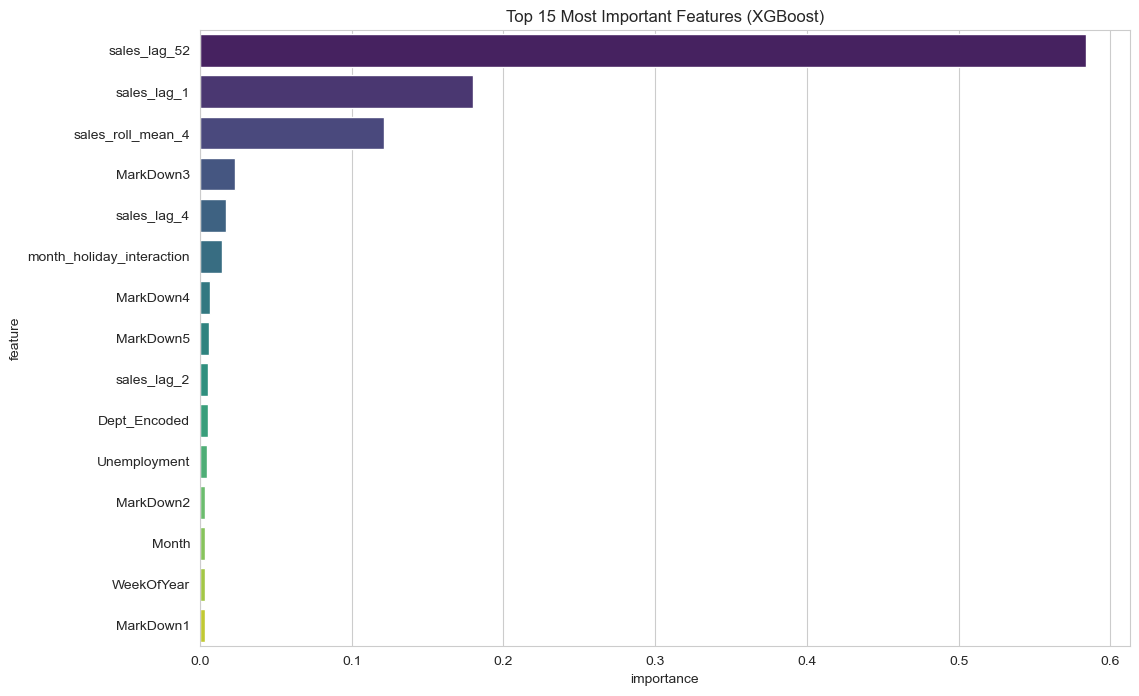

In [5]:
# === FEATURE IMPORTANCE ===
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.show()
